In [2]:
import os
from pathlib import Path, PureWindowsPath
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
from scipy.stats import ttest_ind
import statsmodels.api as sm
from statsmodels.formula.api import ols
import statsmodels.api as sm

# Import Data

In [3]:
os.path.dirname(os.getcwd())

'C:\\Users\\Cornelius\\Cory Dropbox\\Cory LeRoy\\PC\\Documents\\GitHub\\Store-Sales'

In [4]:
path_cwd = Path(PureWindowsPath(os.path.dirname(os.getcwd())))
path_cwd

WindowsPath('C:/Users/Cornelius/Cory Dropbox/Cory LeRoy/PC/Documents/GitHub/Store-Sales')

In [5]:
path = path_cwd / 'data'
path

WindowsPath('C:/Users/Cornelius/Cory Dropbox/Cory LeRoy/PC/Documents/GitHub/Store-Sales/data')

In [6]:
df_train = pd.read_csv(path / 'train.csv')
df_transaction = pd.read_csv(path / 'transactions.csv')
df_holidays = pd.read_csv(path / 'holidays_events.csv')
df_oil = pd.read_csv(path / 'oil.csv')
df_stores = pd.read_csv(path / 'stores.csv')
df_test = pd.read_csv(path / 'test.csv')

In [7]:
df_train.dtypes

id               int64
date            object
store_nbr        int64
family          object
sales          float64
onpromotion      int64
dtype: object

In [8]:
df_train.head()

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0


In [9]:
df_test = pd.read_csv(path / 'test.csv')
df_test

,id,date,store_nbr,family,onpromotion
0,3000888,2017-08-16,1,AUTOMOTIVE,0
1,3000889,2017-08-16,1,BABY CARE,0
2,3000890,2017-08-16,1,BEAUTY,2
3,3000891,2017-08-16,1,BEVERAGES,20
4,3000892,2017-08-16,1,BOOKS,0
...,...,...,...,...,...
28507,3029395,2017-08-31,9,POULTRY,1
28508,3029396,2017-08-31,9,PREPARED FOODS,0
28509,3029397,2017-08-31,9,PRODUCE,1
28510,3029398,2017-08-31,9,SCHOOL AND OFFICE SUPPLIES,9


# Clean Data

In [10]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 6 columns):
 #   Column       Dtype  
---  ------       -----  
 0   id           int64  
 1   date         object 
 2   store_nbr    int64  
 3   family       object 
 4   sales        float64
 5   onpromotion  int64  
dtypes: float64(1), int64(3), object(2)
memory usage: 137.4+ MB


In [11]:
print('max:',df_train['date'].max(), 'min:',df_train['date'].min())

max: 2017-08-15 min: 2013-01-01


In [12]:
df_train['date'] = pd.to_datetime(df_train['date'])

In [13]:
#add time element features
df_train['day'] = df_train['date'].dt.day
df_train['day_of_week'] = df_train['date'].dt.dayofweek
df_train['day_name'] = df_train['date'].dt.day_name()
#df_train['week'] = df_train['date'].dt.isocalendar().week
df_train['month'] = df_train['date'].dt.month
df_train['year'] = df_train['date'].dt.year


## Check for seasonality

In [14]:
df_daily_sales = df_train.groupby('date')['sales'].sum().reset_index()
df_monthly_sales = df_train.groupby(['year','month'])['sales'].sum().reset_index()
df_monthly_sales_by_store = df_train.groupby(['year','month', 'store_nbr'])['sales'].sum().reset_index()

In [15]:
#use rolling avg for SARIMA? maybe not
df_daily_sales['rolling_average_7_day'] = df_daily_sales['sales'].rolling(window=7).mean() 

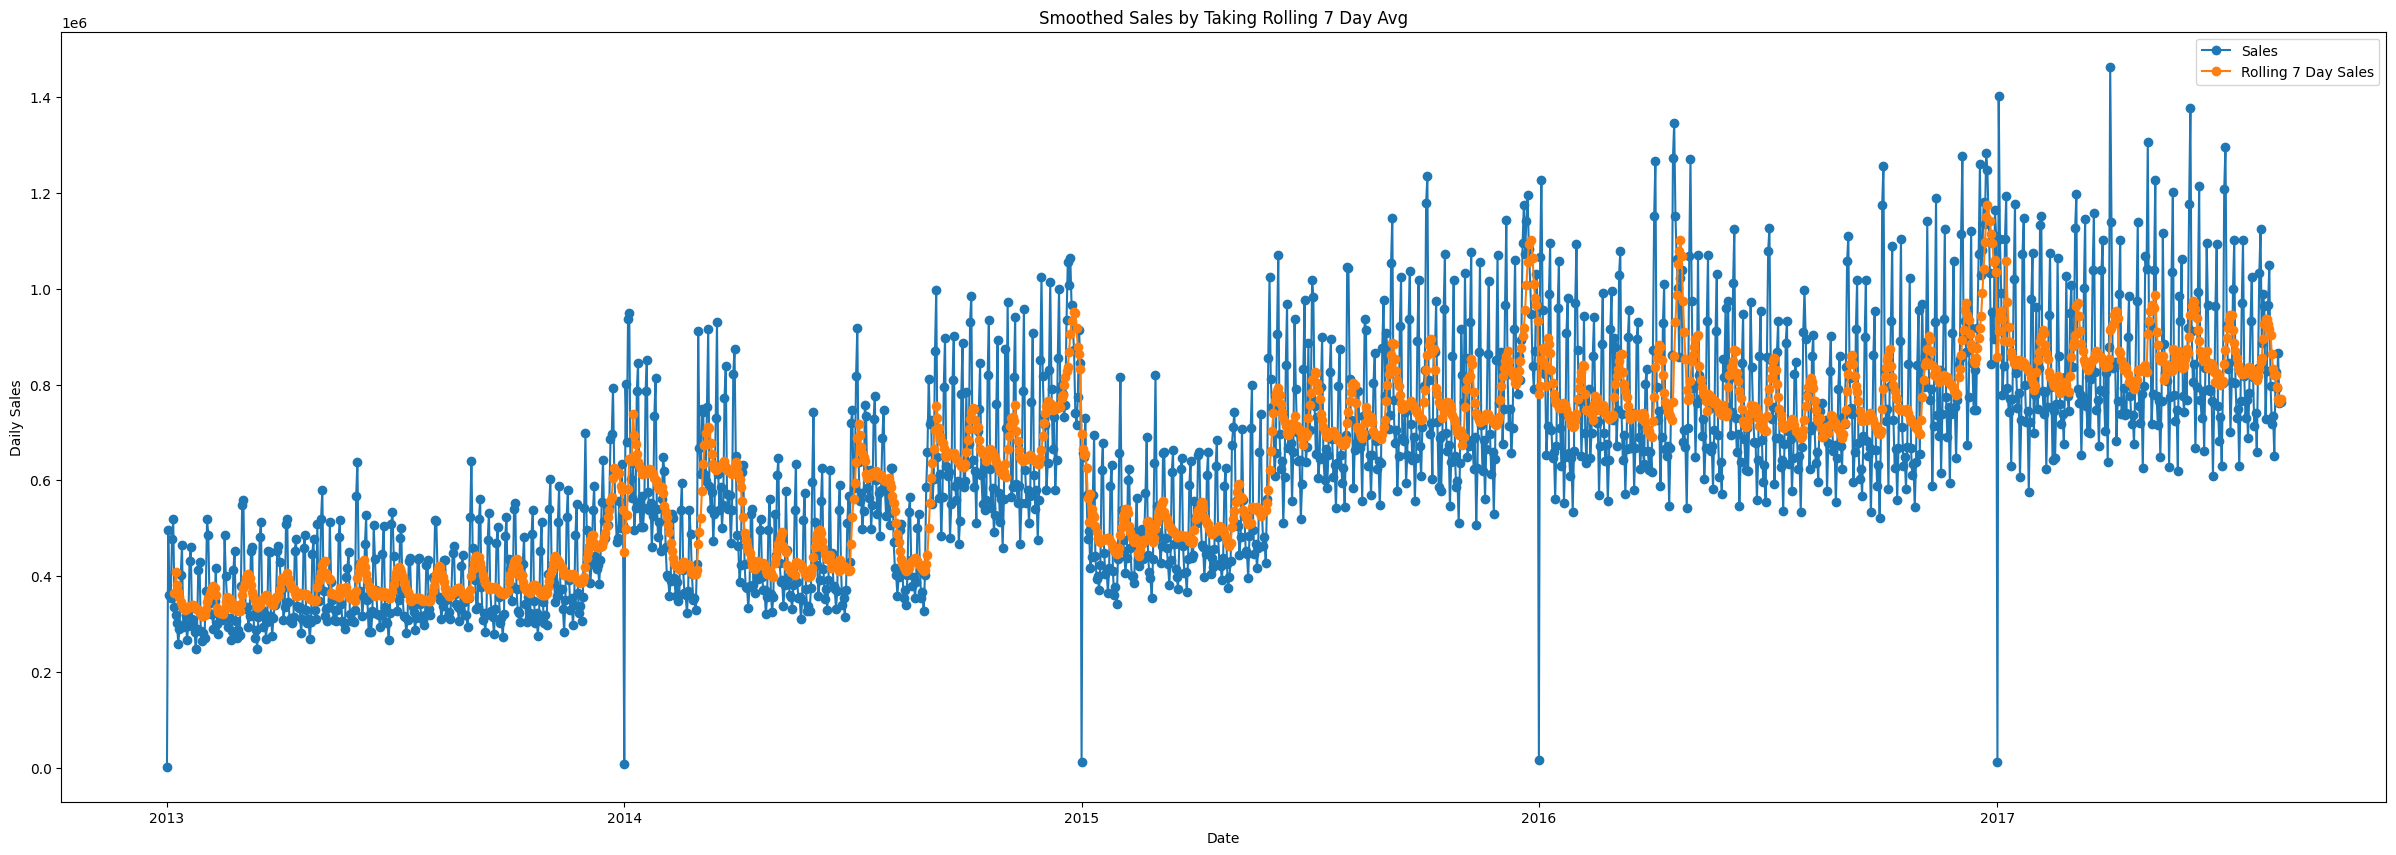

In [16]:

plt.figure(figsize=(30, 10))
plt.plot(df_daily_sales['date'] , df_daily_sales['sales'], label='Sales', marker='o') #, marker='o', color='year')
plt.plot(df_daily_sales['date'] , df_daily_sales['rolling_average_7_day'], label='Rolling 7 Day Sales', marker='o')
#sns.barplot(x=df_monthly_sales['year'].astype(str)+'-'+df_monthly_sales['month'].astype(str), y='sales', hue='year', data=df_monthly_sales, palette='viridis')
plt.xlabel('Date')
plt.ylabel('Daily Sales')
plt.title('Smoothed Sales by Taking Rolling 7 Day Avg')
plt.legend()
plt.show()

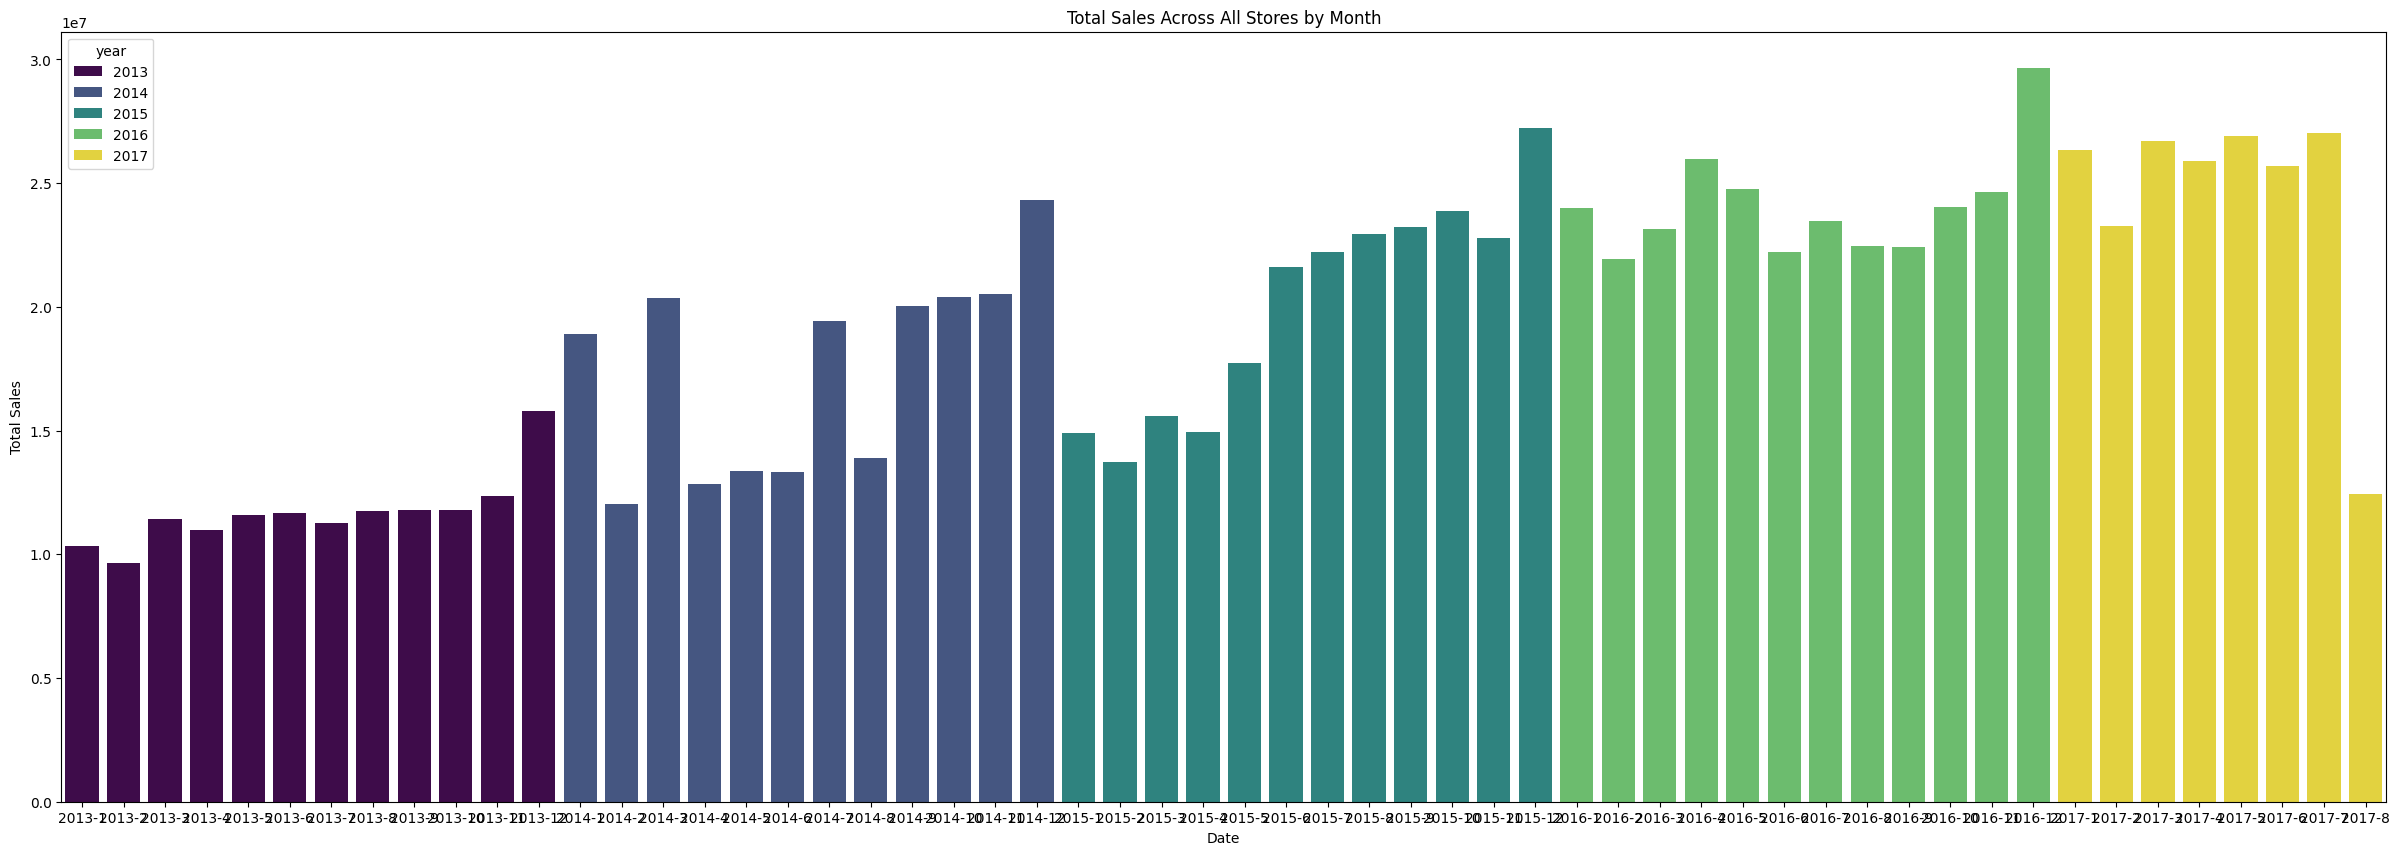

In [17]:
plt.figure(figsize=(30, 10))
#plt.plot(df_monthly_sales['year'].astype(str)+'-'+df_monthly_sales['month'].astype(str) , df_monthly_sales['sales'], marker='o', color='year')
sns.barplot(x=df_monthly_sales['year'].astype(str)+'-'+df_monthly_sales['month'].astype(str), y='sales', hue='year', data=df_monthly_sales, palette='viridis')
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.title('Total Sales Across All Stores by Month')
plt.show()

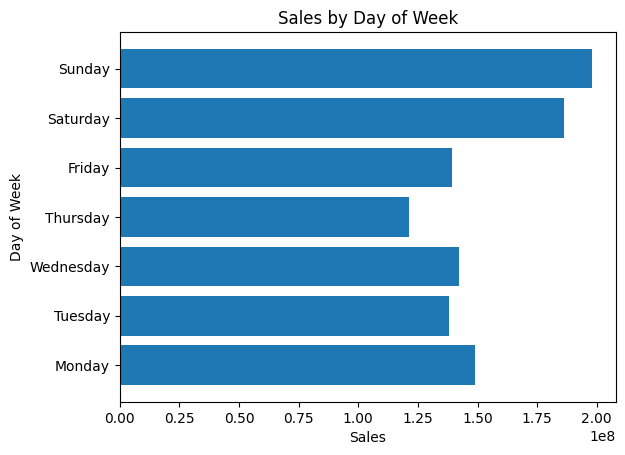

In [18]:
dow_sales = df_train.groupby('day_name')['sales'].sum().reset_index()
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

dow_sales['day_name'] = pd.Categorical(dow_sales['day_name'], categories=day_order, ordered=True)
dow_sales.sort_values('day_name', inplace=True)

plt.barh(dow_sales['day_name'], dow_sales['sales'])
plt.xlabel('Sales')
plt.ylabel('Day of Week')
plt.title('Sales by Day of Week')
plt.show()

there is significant seasonality across days of the week and months in the year. Ex. Sunday and December both usually will have high sales

## check for missing values

In [19]:
### there are stores that werent open in 2013. it would be better to remove those rows

In [20]:
mindate = df_train[df_train['date']=='2013-01-01']
maxdate = df_train[df_train['date']=='2017-08-15']

print(mindate.shape[0], 'rows in the lowest date. ', maxdate.shape[0], 'rows in the max date')

1782 rows in the lowest date.  1782 rows in the max date


In [21]:
rows_per_day = df_train.groupby('date').size()
rows_per_day[rows_per_day!= 1782]

Series([], dtype: int64)

Every day has 1782 entries. That means that there are no missing values for id, store_nbr, or family. If there were no sales, the row will contain a 0 sales value

In [22]:
series_all_dates = df_train['date'].unique()
df_all_dates = pd.DataFrame(series_all_dates)
df_all_dates.to_csv(r'df_all_dates.csv', index=False)  # Set index=False if you don't want to include row numbers in the CSV file
#use this to find missing dates. Xmas is only date missing

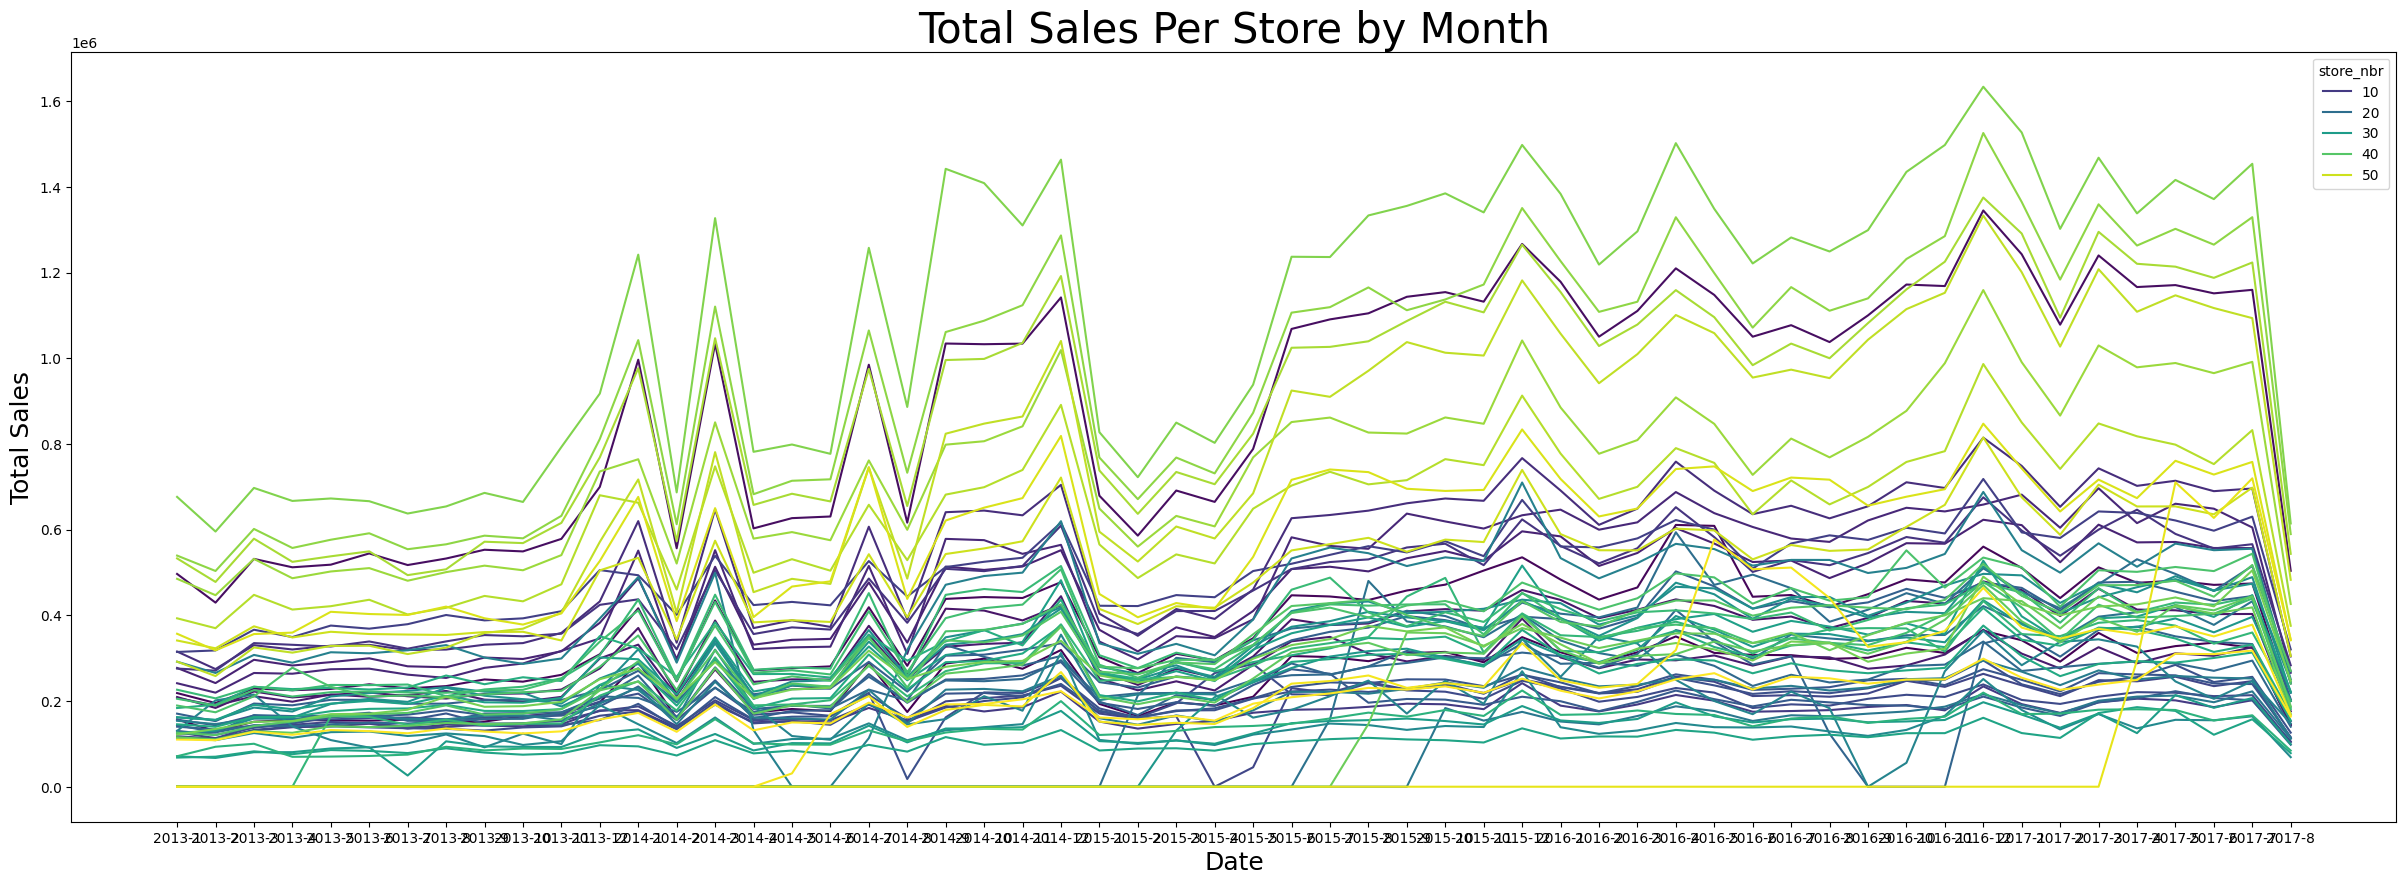

In [23]:
plt.figure(figsize=(30, 10))
#plt.plot(df_monthly_sales['year'].astype(str)+'-'+df_monthly_sales['month'].astype(str) , df_monthly_sales['sales'], marker='o', color='year')
sns.lineplot(x=df_monthly_sales_by_store['year'].astype(str)+'-'+df_monthly_sales_by_store['month'].astype(str), y='sales', hue='store_nbr', data=df_monthly_sales_by_store, palette='viridis')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Total Sales', fontsize=18)
plt.title('Total Sales Per Store by Month', fontsize=30)
plt.show()

In [24]:
#check for stores and categories with 0 sales. remove those rows. 
#certain stores wont have opened in 2013 and certain store probably dont sell certain items?? bad assumption?
df_train.head()
unique_stores = df_train['store_nbr'].drop_duplicates().sort_values()
unique_stores.count()

54

In [25]:
first_sale_date_per_store = df_train[df_train['sales'] > 0].groupby('store_nbr')['date'].min().reset_index()
first_sale_date_per_store

,store_nbr,date
0,1,2013-01-02
1,2,2013-01-02
2,3,2013-01-02
3,4,2013-01-02
4,5,2013-01-02
5,6,2013-01-02
6,7,2013-01-02
7,8,2013-01-02
8,9,2013-01-02
9,10,2013-01-02


In [26]:
def train_to_store_merge(train, store):
    df_train_store_merged = pd.merge(train, store, how='left', on='store_nbr')
    return df_train_store_merged


In [27]:
df_train_min_date = pd.merge(df_train, first_sale_date_per_store, on='store_nbr')
df_train_shortened = df_train_min_date[df_train_min_date['date_x'] >= df_train_min_date['date_y']] 
df_train_shortened = df_train_shortened.drop(['date_y'], axis=1)
df_train_shortened.rename(columns={'date_x':'date'}, inplace=True)
df_train_shortened = train_to_store_merge(df_train_shortened, df_stores)
df_train_shortened
### store 25 was closed from 2016-08-23 to 2016-10-26. remove these rows
## store 16 was closed from 2016-08-15 to 2016-12-02. remove these rows
# store 24 was closed from 2014-04-14 to 2014-07-23

,id,date,store_nbr,family,sales,onpromotion,day,day_of_week,day_name,month,year,city,state,type,cluster
0,1782,2013-01-02,1,AUTOMOTIVE,2.000,0,2,2,Wednesday,1,2013,Quito,Pichincha,D,13
1,1783,2013-01-02,1,BABY CARE,0.000,0,2,2,Wednesday,1,2013,Quito,Pichincha,D,13
2,1784,2013-01-02,1,BEAUTY,2.000,0,2,2,Wednesday,1,2013,Quito,Pichincha,D,13
3,1785,2013-01-02,1,BEVERAGES,1091.000,0,2,2,Wednesday,1,2013,Quito,Pichincha,D,13
4,1786,2013-01-02,1,BOOKS,0.000,0,2,2,Wednesday,1,2013,Quito,Pichincha,D,13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2778826,3000883,2017-08-15,9,POULTRY,438.133,0,15,1,Tuesday,8,2017,Quito,Pichincha,B,6
2778827,3000884,2017-08-15,9,PREPARED FOODS,154.553,1,15,1,Tuesday,8,2017,Quito,Pichincha,B,6
2778828,3000885,2017-08-15,9,PRODUCE,2419.729,148,15,1,Tuesday,8,2017,Quito,Pichincha,B,6
2778829,3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000,8,15,1,Tuesday,8,2017,Quito,Pichincha,B,6


In [53]:

# Sort DataFrame by 'store_number' and 'date'
df_date_filter = df_train_shortened.sort_values(by=['store_nbr', 'date'])

# Calculate difference between consecutive dates for each store
df_date_filter['date_diff'] = df_date_filter.groupby('store_nbr')['date'].diff()

# Filter periods where sales were 0 for longer than 1 month for each store
zero_sales_periods = df_date_filter[df_date_filter['sales'] == 0].groupby('store_nbr')['date_diff'].apply(lambda x: x.dt.days >= 30).any(axis=1)
zero_sales_windows = df_date_filter[df_date_filter['store_nbr'].isin(zero_sales_periods.index) & zero_sales_periods]
zero_sales_windows

AttributeError: 'numpy.bool_' object has no attribute 'index'

### Always predict 0 for items that are never sold at stores? ###

In [28]:
never_sold = df_train_shortened.groupby(['store_nbr','family'])['sales'].sum().reset_index()
never_sold = never_sold[never_sold['sales']==0].sort_values(['store_nbr','family'])
never_sold

,store_nbr,family,sales
1,1,BABY CARE,0.0
268,9,BOOKS,0.0
301,10,BOOKS,0.0
334,11,BOOKS,0.0
367,12,BOOKS,0.0
397,13,BABY CARE,0.0
400,13,BOOKS,0.0
433,14,BOOKS,0.0
449,14,LAWN AND GARDEN,0.0
466,15,BOOKS,0.0


## Sales Distributions per Category

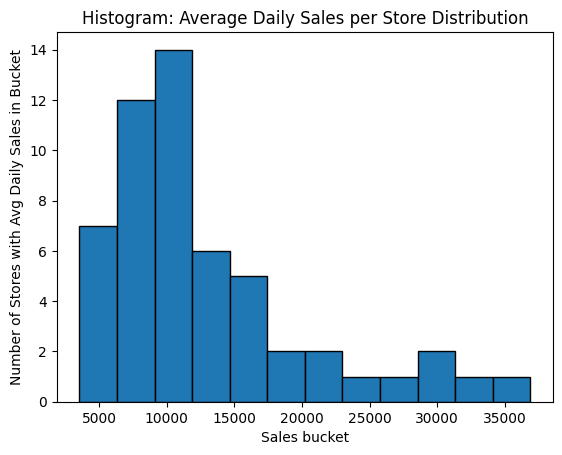

In [29]:
total_sales_per_store_daily = df_train_shortened.groupby(['store_nbr','date'])['sales'].sum().reset_index()
avg_sales_per_store = total_sales_per_store_daily.groupby(['store_nbr'])['sales'].mean().reset_index()
# Plot the bar chart
plt.hist(avg_sales_per_store['sales'], bins = 12, edgecolor = 'black')
plt.xlabel('Sales bucket')
plt.ylabel('Number of Stores with Avg Daily Sales in Bucket')
plt.title('Histogram: Average Daily Sales per Store Distribution')
plt.show()



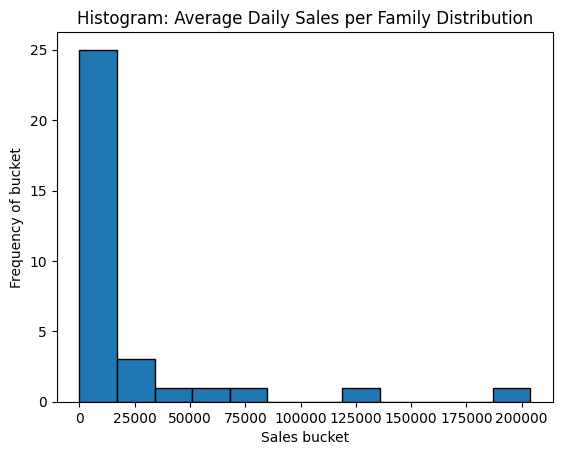

In [30]:
total_sales_per_family_daily = df_train_shortened.groupby(['family','date'])['sales'].sum().reset_index()
avg_sales_per_family = total_sales_per_family_daily.groupby(['family'])['sales'].mean().reset_index()
# Plot the bar chart
plt.hist(avg_sales_per_family['sales'], bins = 12, edgecolor = 'black')
plt.xlabel('Sales bucket')
plt.ylabel('Frequency of bucket')
plt.title('Histogram: Average Daily Sales per Family Distribution')
plt.show()


In [31]:
outlier_families = avg_sales_per_family[avg_sales_per_family['sales']>100000]
outlier_families

,family,sales
3,BEVERAGES,128832.830166
12,GROCERY I,203956.493400


the avg daily sales per store looks like a normal distribution with a right skew. <br> the avg daily sales per family chart has most families grouping on the low sales with 2 huge outliers, beverages and groceries


In [32]:
df_train

,id,date,store_nbr,family,sales,onpromotion,day,day_of_week,day_name,month,year
0,0,2013-01-01,1,AUTOMOTIVE,0.000,0,1,1,Tuesday,1,2013
1,1,2013-01-01,1,BABY CARE,0.000,0,1,1,Tuesday,1,2013
2,2,2013-01-01,1,BEAUTY,0.000,0,1,1,Tuesday,1,2013
3,3,2013-01-01,1,BEVERAGES,0.000,0,1,1,Tuesday,1,2013
4,4,2013-01-01,1,BOOKS,0.000,0,1,1,Tuesday,1,2013
...,...,...,...,...,...,...,...,...,...,...,...
3000883,3000883,2017-08-15,9,POULTRY,438.133,0,15,1,Tuesday,8,2017
3000884,3000884,2017-08-15,9,PREPARED FOODS,154.553,1,15,1,Tuesday,8,2017
3000885,3000885,2017-08-15,9,PRODUCE,2419.729,148,15,1,Tuesday,8,2017
3000886,3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000,8,15,1,Tuesday,8,2017


C:\Users\Cornelius\AppData\Local\Temp\ipykernel_20572\2034698893.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  a["ind"] = 1
C:\Users\Cornelius\AppData\Local\Temp\ipykernel_20572\2034698893.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  a["ind"] = a.groupby("family").ind.cumsum().values


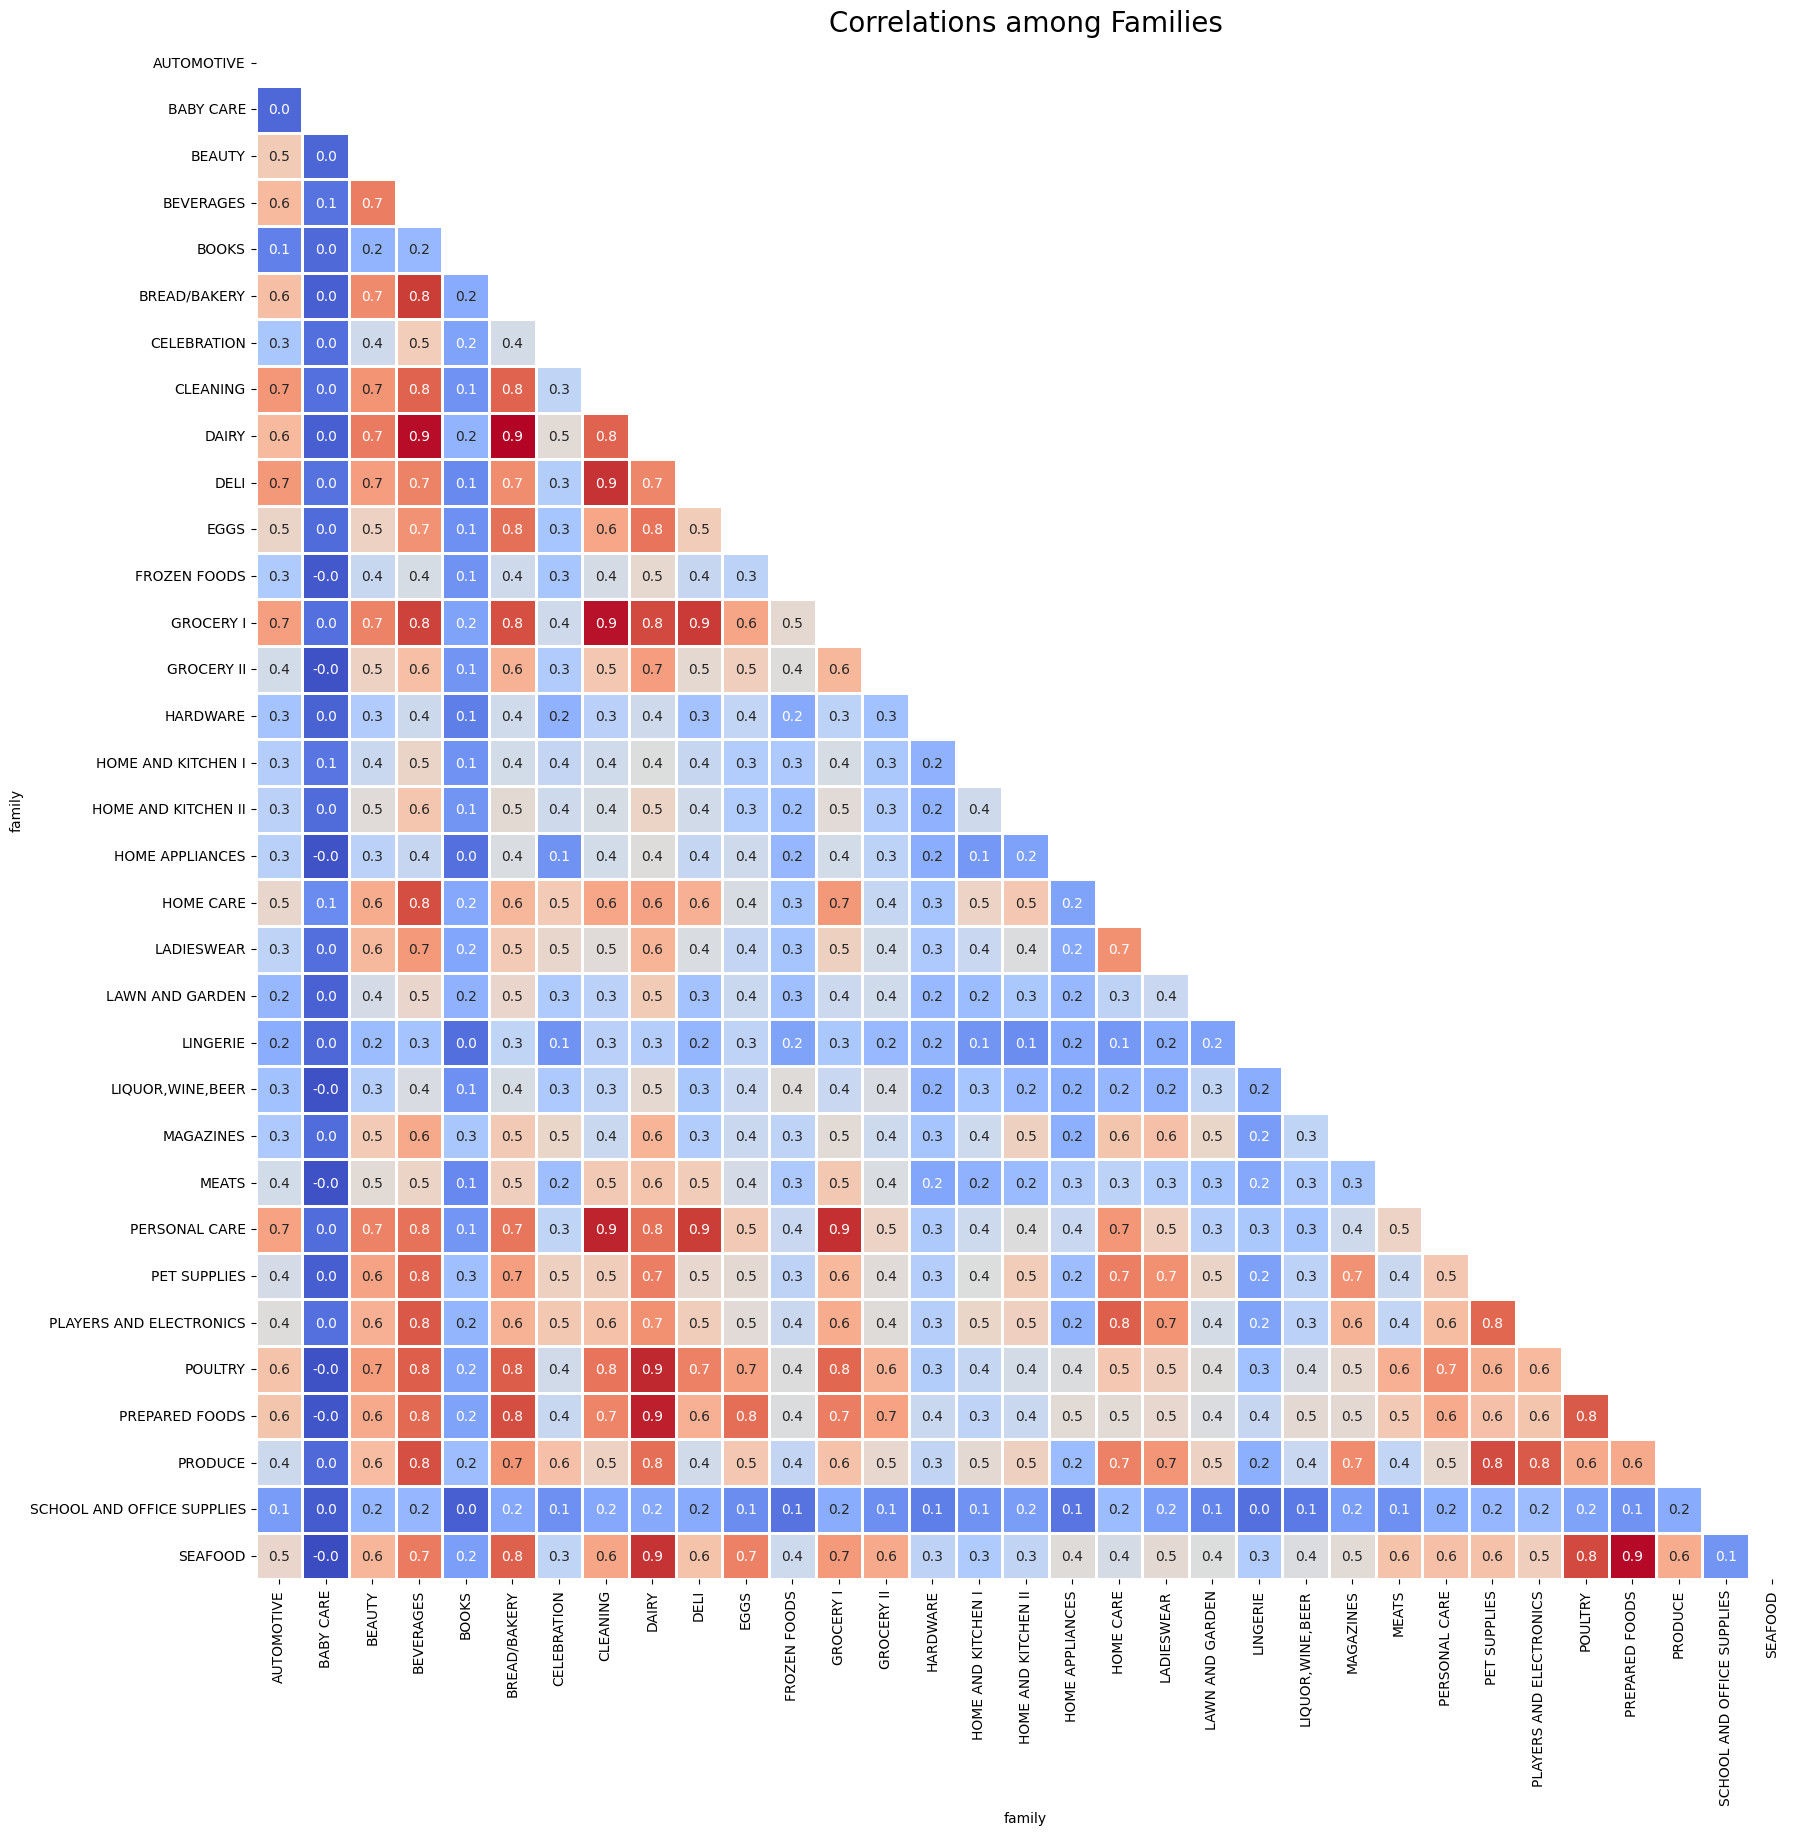

In [33]:
a = df_train[["family", "sales"]]
a["ind"] = 1
a["ind"] = a.groupby("family").ind.cumsum().values
a = pd.pivot(a, index = "ind", columns = "family", values = "sales").corr()
mask = np.triu(a.corr())
plt.figure(figsize=(20, 20))
sns.heatmap(a,
        annot=True,
        fmt='.1f',
        cmap='coolwarm',
        square=True,
        mask=mask,
        linewidths=1,
        cbar=False)
plt.title("Correlations among Families",fontsize = 20)
plt.show()

In [34]:
len(df_train['family'].unique())

33

## Holidays ###

#### clean holidays data

In [35]:
df_holidays['date'] = pd.to_datetime(df_holidays['date'])

In [36]:
# transferred  = True is a holiday that was observed on a different day
df_holidays_real = df_holidays[df_holidays['transferred']==False] 
df_holidays_real['date'].value_counts()

date
2014-06-25    4
2015-06-25    3
2012-06-25    3
2017-06-25    3
2013-06-25    3
             ..
2014-08-05    1
2014-08-10    1
2014-08-15    1
2014-08-24    1
2017-12-26    1
Name: count, Length: 300, dtype: int64

In [37]:

unique_holis2 = df_holidays_real[['description','locale']].drop_duplicates()
unique_holis_national = unique_holis2[unique_holis2['locale']=='National'].drop(['locale'],axis=1)
unique_holis_city = unique_holis2[unique_holis2['locale']=='Local'].drop(['locale'],axis=1)
unique_holis_state = unique_holis2[unique_holis2['locale']=='Regional'].drop(['locale'],axis=1)

In [38]:
#sum up sales per day to analyze holidays
#df_train_summed_daily = df_train_shortened.groupby(['date']).agg({'onpromotion':'sum', 'sales':'sum'}).reset_index()
df_train_summed_daily = df_train_shortened.groupby(['date','city','state']).agg({'onpromotion':'sum', 'sales':'sum'}).reset_index()
df_train_summed_daily

,date,city,state,onpromotion,sales
0,2013-01-01,Salinas,Santa Elena,0,2511.618999
1,2013-01-02,Ambato,Tungurahua,0,23136.469000
2,2013-01-02,Babahoyo,Los Rios,0,6637.560000
3,2013-01-02,Cayambe,Pichincha,0,18329.638000
4,2013-01-02,Cuenca,Azuay,0,21068.210009
...,...,...,...,...,...
35376,2017-08-15,Quevedo,Los Rios,258,11649.571000
35377,2017-08-15,Quito,Pichincha,3334,341655.357968
35378,2017-08-15,Riobamba,Chimborazo,215,9342.732000
35379,2017-08-15,Salinas,Santa Elena,85,6522.788000


In [39]:

national_holidays = df_holidays_real[df_holidays_real['locale']=='National'].loc[:,('date','description')]
local_holidays = df_holidays_real[df_holidays_real['locale']=='Local'].loc[:,('date','description','locale_name')]
state_holidays = df_holidays_real[df_holidays_real['locale']=='Regional'].loc[:,('date','description','locale_name')]

In [40]:
#combine training set with holidays
#df_holi = pd.merge(df_train_summed_daily, national_holidays, how='left', on='date')
#df_holi_state = pd.merge(df_train_summed_daily, state_holidays, how='inner', left_on=['date', 'state'], right_on=['date','locale_name'])
#df_holi_city = pd.merge(df_train_summed_daily, local_holidays, how='inner', left_on=['date', 'city'], right_on=['date','locale_name'])

df_holi = pd.merge(df_train_summed_daily, national_holidays, how='left', on='date')
df_holi = pd.merge(df_holi, state_holidays, how='left', left_on=['date', 'state'], right_on=['date','locale_name'])
df_holi = pd.merge(df_holi, local_holidays, how='left', left_on=['date', 'city'], right_on=['date','locale_name'])

df_holi = df_holi.drop(['locale_name_x','locale_name_y'],axis=1)
df_holi = df_holi.rename(columns = {'description_x':'national_holiday','description_y':'state_holiday','description':'city_holiday'})
#has dups
#now aggregate per city

In [41]:
df_holi

,date,city,state,onpromotion,sales,national_holiday,state_holiday,city_holiday
0,2013-01-01,Salinas,Santa Elena,0,2511.618999,Primer dia del ano,NaN,NaN
1,2013-01-02,Ambato,Tungurahua,0,23136.469000,NaN,NaN,NaN
2,2013-01-02,Babahoyo,Los Rios,0,6637.560000,NaN,NaN,NaN
3,2013-01-02,Cayambe,Pichincha,0,18329.638000,NaN,NaN,NaN
4,2013-01-02,Cuenca,Azuay,0,21068.210009,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
35464,2017-08-15,Quevedo,Los Rios,258,11649.571000,NaN,NaN,NaN
35465,2017-08-15,Quito,Pichincha,3334,341655.357968,NaN,NaN,NaN
35466,2017-08-15,Riobamba,Chimborazo,215,9342.732000,NaN,NaN,Fundacion de Riobamba
35467,2017-08-15,Salinas,Santa Elena,85,6522.788000,NaN,NaN,NaN


In [42]:
#df_holi = pd.merge(df_train_summed_daily, national_holidays, how='left', on='date')
#df_holi = pd.merge(df_holi, state_holidays, how='left', left_on=['date', 'state'], right_on=['date','locale_name'])
##df_holi[(df_holi['date']=='2016-05-07') & (df_holi['state']=='Imbabura') ]
#national_holidays[national_holidays['date']=='2016-05-07']

In [43]:

df_holi[(df_holi['date']=='2016-05-12') & (df_holi['city']=='Puyo') ]
#df_holi[(df_holi['state_holiday'].notnull()) ]

,date,city,state,onpromotion,sales,national_holiday,state_holiday,city_holiday
25364,2016-05-12,Puyo,Pastaza,98,4032.34,Terremoto Manabi+26,NaN,Cantonizacion del Puyo


In [44]:
# joing train to holidays. will create duplicate when a there are multiple holidays falling on same date
#df_holi = pd.merge(df_train_summed_daily, df_holidays_real, on='date', how='left')
#df_holi
# wont need this section anymore


In [45]:
# set boolean column for each unique holiday. still have dups

for holiday in unique_holis_national['description'].tolist():
    df_holi[holiday] = df_holi['national_holiday'] == holiday
for holiday in unique_holis_state['description'].tolist():
    df_holi[holiday] = df_holi['state_holiday'] == holiday
for holiday in unique_holis_city['description'].tolist():
    df_holi[holiday] = df_holi['city_holiday'] == holiday

df_holi = df_holi.drop(['national_holiday','state_holiday','city_holiday'] ,axis=1)


C:\Users\Cornelius\AppData\Local\Temp\ipykernel_20572\376379524.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_holi[holiday] = df_holi['city_holiday'] == holiday
C:\Users\Cornelius\AppData\Local\Temp\ipykernel_20572\376379524.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_holi[holiday] = df_holi['city_holiday'] == holiday
C:\Users\Cornelius\AppData\Local\Temp\ipykernel_20572\376379524.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which 

In [46]:
df_holi

,date,city,state,onpromotion,sales,Primer Grito de Independencia,Traslado Independencia de Guayaquil,Dia de Difuntos,Independencia de Cuenca,Navidad-4,...,Independencia de Latacunga,Independencia de Ambato,Fundacion de Quito-1,Fundacion de Quito,Fundacion de Loja,Cantonizacion de Salinas,Fundacion de Guayaquil-1,Fundacion de Guayaquil,Traslado Fundacion de Guayaquil,Traslado Fundacion de Quito
0,2013-01-01,Salinas,Santa Elena,0,2511.618999,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,2013-01-02,Ambato,Tungurahua,0,23136.469000,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,2013-01-02,Babahoyo,Los Rios,0,6637.560000,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,2013-01-02,Cayambe,Pichincha,0,18329.638000,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,2013-01-02,Cuenca,Azuay,0,21068.210009,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35464,2017-08-15,Quevedo,Los Rios,258,11649.571000,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
35465,2017-08-15,Quito,Pichincha,3334,341655.357968,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
35466,2017-08-15,Riobamba,Chimborazo,215,9342.732000,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
35467,2017-08-15,Salinas,Santa Elena,85,6522.788000,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [47]:
#example dup
a = df_holi[(df_holi['date']=='2016-05-07')& (df_holi['city']=='Ambato')]
a.iloc[:,60:80]
#a['Dia de la Madre-1']
#df_holi.iloc[35466,15:40]


,Terremoto Manabi+19,Terremoto Manabi+20,Terremoto Manabi+21,Terremoto Manabi+22,Terremoto Manabi+23,Terremoto Manabi+24,Terremoto Manabi+25,Terremoto Manabi+26,Terremoto Manabi+27,Terremoto Manabi+28,Terremoto Manabi+29,Terremoto Manabi+30,Traslado Batalla de Pichincha,Traslado Primer Grito de Independencia,Puente Dia de Difuntos,Recupero Puente Dia de Difuntos,Traslado Primer dia del ano,Provincializacion de Cotopaxi,Provincializacion de Imbabura,Provincializacion de Santo Domingo
25194,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
25195,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False


In [48]:
#find days with multiple holidays
#df_holi_dup_test = df_holidays_real.groupby('date').size().reset_index(name='count')
#df_holi_dup_test = df_holi_dup_test[df_holi_dup_test['count'] > 1]
#df_holi_dup_test.sort_values(by='count')

In [49]:
#df_holi_summed_daily = df_holi.groupby(['date','city','state', 'description']).agg({'onpromotion':'sum', 'sales':'sum'}).reset_index()
# i think not necessary anymore

In [50]:
# combines duplicates rows into 1 rows where there is a true for each holiday that falls on the given date
unique_holis_list = list(unique_holis)
agg_func = {col: 'any' for col in unique_holis_list}
aggregated_df = df_holi.groupby(['date','sales','city','state','onpromotion']).agg(agg_func).reset_index()
aggregated_df = pd.get_dummies(aggregated_df, columns=['city', 'state'], prefix=['city', 'state'])

NameError: name 'unique_holis' is not defined

In [ ]:
a = aggregated_df[(aggregated_df['date']=='2016-05-07')& (aggregated_df['city_Ambato']==1)]
b = a['Dia de la Madre-1']
c = a['Terremoto Manabi+21']
a

#### OLS to determine impact of each holiday across all stores

In [ ]:
#testing a date that has multiple holidays
aggregated_df[aggregated_df['Independencia de Cuenca']]

In [ ]:
#aggregated_df_ols = df_holi.groupby(['date','onpromotion']).agg(agg_func).reset_index()
# cant remember if this was used...

In [ ]:
# sum everything for the date, not analyzing if holidays impact store or family bc it produces too many variables for OLS
# aggregated_df_ols = aggregated_df.drop(['family','store_nbr'],axis=1)
# believe this is obsoleted

In [ ]:
# seasonality has big impact on predicted sales so need to add some variables to capture 
aggregated_df_ols = aggregated_df.copy()
aggregated_df_ols['dow'] = aggregated_df_ols['date'].dt.dayofweek
aggregated_df_ols['month'] = aggregated_df_ols['date'].dt.month
aggregated_df_ols['year'] = aggregated_df_ols['date'].dt.year
aggregated_df_ols = aggregated_df_ols.drop('date',axis=1)

In [ ]:
#model seasonality with dummy vars... do i need this?
aggregated_df_ols_dummies =  pd.get_dummies(aggregated_df_ols, columns=['dow','month', 'year'], drop_first=True)

In [ ]:
X = aggregated_df_ols_dummies.drop('sales',axis=1)
# add constant for linear regression
X = sm.add_constant(X)
X = X.astype(int)
y=aggregated_df_ols_dummies['sales']

In [ ]:
print(X.shape, X.shape[0],'rows and', X.shape[1], 'columns.  OLS conditions are met (10-20x rows for each column)')

In [ ]:
model_OLS = sm.OLS(y,X).fit()

In [ ]:
model_summary = model_OLS.summary()
print(model_summary)
#p values less then .05 are significant

In [ ]:
# Get the summary results as a DataFrame
summary_df = pd.read_html(model_summary.tables[1].as_html(), header=0, index_col=0)[0]
summary_df.to_csv('ols_summary_results.csv')

In [ ]:
#! pip install lxml

In [ ]:
# remove features that have p value >.10 
# ... no xmas day in trainset
pvalues = model_OLS.pvalues
alpha = .05
drop_columns = pvalues[pvalues>alpha]
drop_cols = list(drop_columns.index)
# manually keeping non holiday columns
#most date columns were significant except for these 3 months. still would like to keep so there arent holes in date
drop_cols.remove('month_3')
drop_cols.remove('month_7')
drop_cols.remove('month_9')
drop_cols.remove('month_10')
drop_cols.remove('month_11')
drop_cols.remove('city_Ambato')
drop_cols.remove('state_Tungurahua')
drop_cols.remove('state_Guayas')

#train_data.drop(columns=drop_cols)
print(len(drop_cols), 'holidays droped out of', len(unique_holis),'.', len(unique_holis)-len(drop_cols) ,'unique holidays remain' )

In [ ]:
df_holi_shortened = df_holidays_real[~df_holidays_real['description'].isin(drop_cols)]
df_holi_shortened = df_holi_shortened.drop(['type','locale','locale_name','transferred'],axis=1)
df_holi_shortened

In [ ]:
#338 to 108 holidays. 15 unique holidays. some holidays are outside of train and test date range
df_holi_shortened['description'].value_counts().sort_values(ascending=False)

#### redone train set with holidays ####

In [ ]:
# still have dates with multiple holidays 
# 2017-12-22 has two holidays
# no longer have dups once holidays have been removed
df_holi_shortened['date'].value_counts().sort_values(ascending=False)

In [ ]:
unique_holidays = df_holi_shortened['description'].unique()
sorted(unique_holidays)


In [ ]:
filtered_holidays = df_holidays[df_holidays['description'].isin(unique_holidays)]
filtered_holidays

In [ ]:
#separate these out because they have differenct merge conditions
national_holidays_filtered = filtered_holidays[filtered_holidays['locale']=='National'].loc[:,('date','description')]
local_holidays_filtered = filtered_holidays[filtered_holidays['locale']=='Local'].loc[:,('date','description','locale_name')]
state_holidays_filtered = filtered_holidays[filtered_holidays['locale']=='Regional'].loc[:,('date','description','locale_name')]

In [ ]:
df_train_shortened

In [ ]:
def train_to_holiday_merge(train, national_holidays_filtered, state_holidays_filtered, local_holidays_filtered):
    train['date'] = pd.to_datetime(train['date'])
    df_train_filtered = pd.merge(train, national_holidays_filtered, how='left', on='date')
    df_train_filtered = pd.merge(df_train_filtered, state_holidays_filtered, how='left', left_on=['date', 'state'], right_on=['date','locale_name'])
    df_train_filtered = pd.merge(df_train_filtered, local_holidays_filtered, how='left', left_on=['date', 'city'], right_on=['date','locale_name'])
    df_train_filtered['holiday'] = df_train_filtered['description_x'].combine_first(df_train_filtered['description_y']).combine_first(df_train_filtered['description'])

    df_train_filtered = df_train_filtered.drop(['locale_name_x','locale_name_y','description','description_x','description_y'],axis=1)
    return df_train_filtered
df_train_filtered = train_to_holiday_merge(df_train_shortened, national_holidays_filtered, state_holidays_filtered,local_holidays_filtered)
df_train_filtered[df_train_filtered['date']=='2015-12-22']
#df_holi = df_holi.rename(columns = {'description_x':'national_holiday','description_y':'state_holiday','description':'city_holiday'})

# set boolean column for each unique holiday
df_holiday_shortened = df_holi_shortened.copy()
for holiday in unique_holidays:
    df_holiday_shortened[holiday] = df_holiday_shortened['description'] == holiday
#df_holiday_shortened = df_holiday_shortened.drop('description', axis=1)
#dont drop description yet. might be useful later if we dont wanna use extended columns


unique_holidays_list = list(unique_holidays)
agg_func = {col: 'any' for col in unique_holidays_list}
df_holiday_shortened = df_holiday_shortened.groupby(['date']).agg(agg_func).reset_index()
df_holiday_shortened

## store groupings ##

In [ ]:
df_stores
#54 stores, 17 clusters

## final df ##

In [ ]:
train_final = train_to_holiday_merge(df_train_shortened, national_holidays_filtered, state_holidays_filtered, local_holidays_filtered)
train_final

In [ ]:
df_test_transformed = train_to_store_merge(df_test, df_stores)
df_test_transformed = train_to_holiday_merge(df_test_transformed, national_holidays_filtered, state_holidays_filtered, local_holidays_filtered)
df_test_transformed